# 1. Config the Environment

In [1]:
from ctypes import *
lib8 = cdll.LoadLibrary('/home/users/vo836354/.conda/envs/test/lib/libcudnn.so.8')

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
#import os
#os.environ["OMP_NUM_THREADS"] = "5"


print(f'python version: {sys.version}')
print(f'tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'numpy version: {np.__version__}')

python version: 3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
tensorflow version: 2.9.1
keras version: 2.9.0
numpy version: 1.22.4


In [3]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
len(tf.config.list_physical_devices('GPU'))

1

In [5]:
from art.attacks.evasion.hop_skip_jump import HopSkipJump


from art.estimators.classification import TensorFlowV2Classifier

/home/users/vo836354/.conda/envs/test/lib/python3.10/site-packages/art/estimators/certification/__init__.py:13: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


In [6]:
# Load data and normalize
from art.utils import load_cifar10
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog','horse', 'ship', 'truck']

In [7]:
#x_train, y_train = tf.cast(x_train, tf.float32), tf.cast(y_train, tf.float32)

In [8]:
min_ = 0
max_ = 1

In [9]:
# Select 10 and 100 random simple from Test set to test the algorithm
random_sample_10 = np.random.randint(low = 0, high = 10000, size = 10)
random_sample_10 = np.sort(random_sample_10).tolist()

random_sample_100 = np.random.randint(low = 0, high = 10000, size = 100)
random_sample_100 = np.sort(random_sample_100).tolist()

#x_test_10 = x_test[random_sample_10,:,:,:]
#x_test_100 = x_test[random_sample_100,:,:,:]

x_test_10 = x_test[random_sample_10,:]
x_test_100 = x_test[random_sample_100,]

y_test_10 = y_test[random_sample_10, :]
y_test_100 = y_test[random_sample_100, :]


In [10]:
x_test_10_ori = x_test_10.copy()
x_test_100_ori = x_test_100.copy()

# 2 Config CNN model

In [11]:
model = tf.keras.models.load_model('../../../../build/saved_model/Simple_CNN/HDF5/Simple_CN.h5', compile=True)

2022-07-21 12:07:25.723196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 12:07:26.413549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7475 MB memory:  -> device: 0, name: Tesla M10, pci bus id: 0000:3d:00.0, compute capability: 5.0


In [12]:
# Create the ART classifier, pass the model to the ART classifier

classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), clip_values=(min_, max_))
#, clip_values=(min_, max_)

In [13]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

2022-07-21 12:07:27.467154: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


Accuracy on benign test examples: 62.81%


# 3 Square Attack


## 3.1 Test Target Attack

### 3.1.1 L-2 attack

In [14]:
attack = HopSkipJump(classifier=classifier, targeted=False, norm=2, max_iter=20, max_eval=100, init_eval=10, verbose=False)

In [15]:
x_test_adv = attack.generate(x=x_test_10_ori)

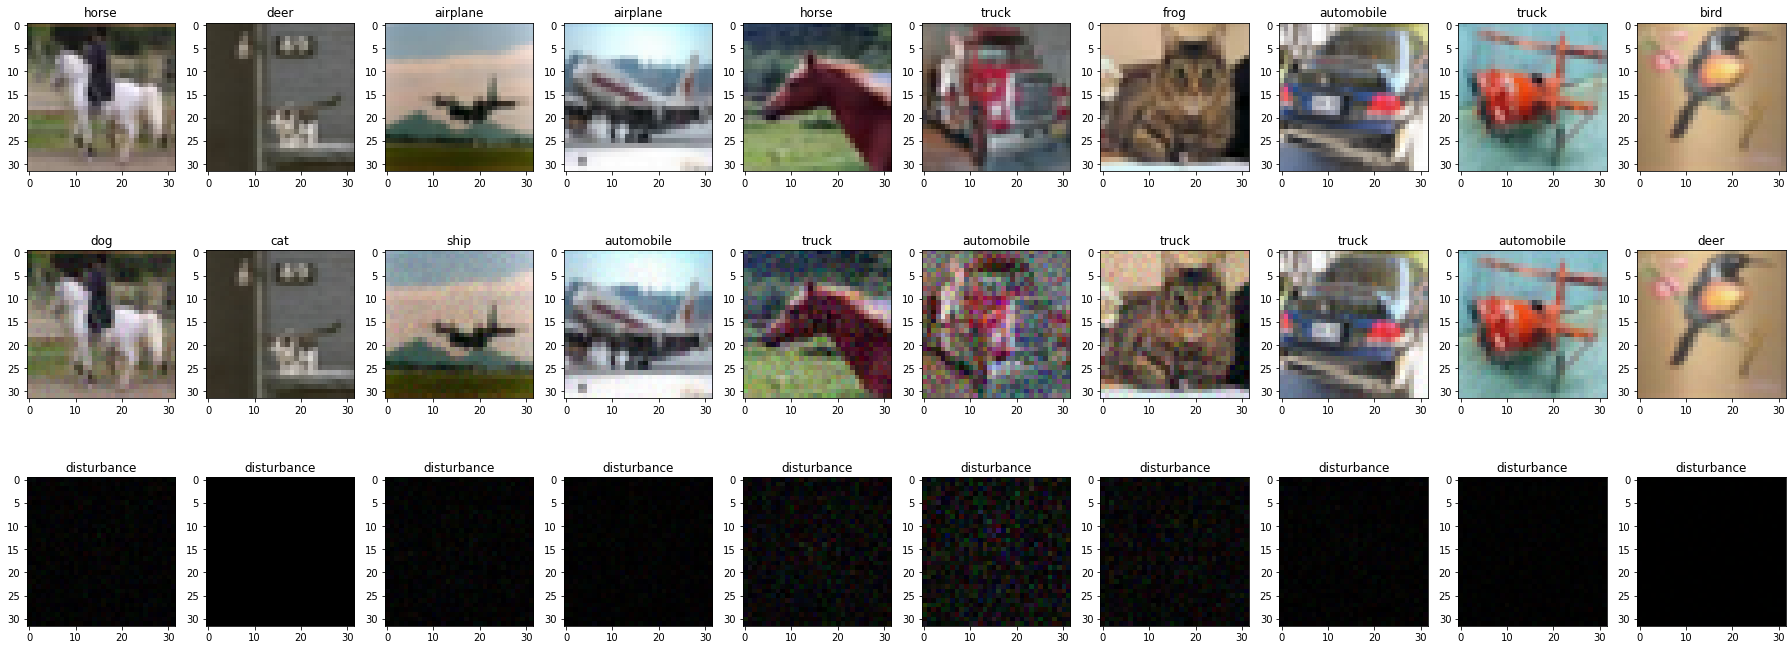

In [16]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.2 L-infinite attack

In [17]:
attack = HopSkipJump(classifier=classifier, targeted=False, norm=np.inf, max_iter=20, max_eval=100, init_eval=10, verbose=False)

Use 10 samples for showing difference and effects

In [18]:
x_test_adv = attack.generate(x=x_test_10_ori)

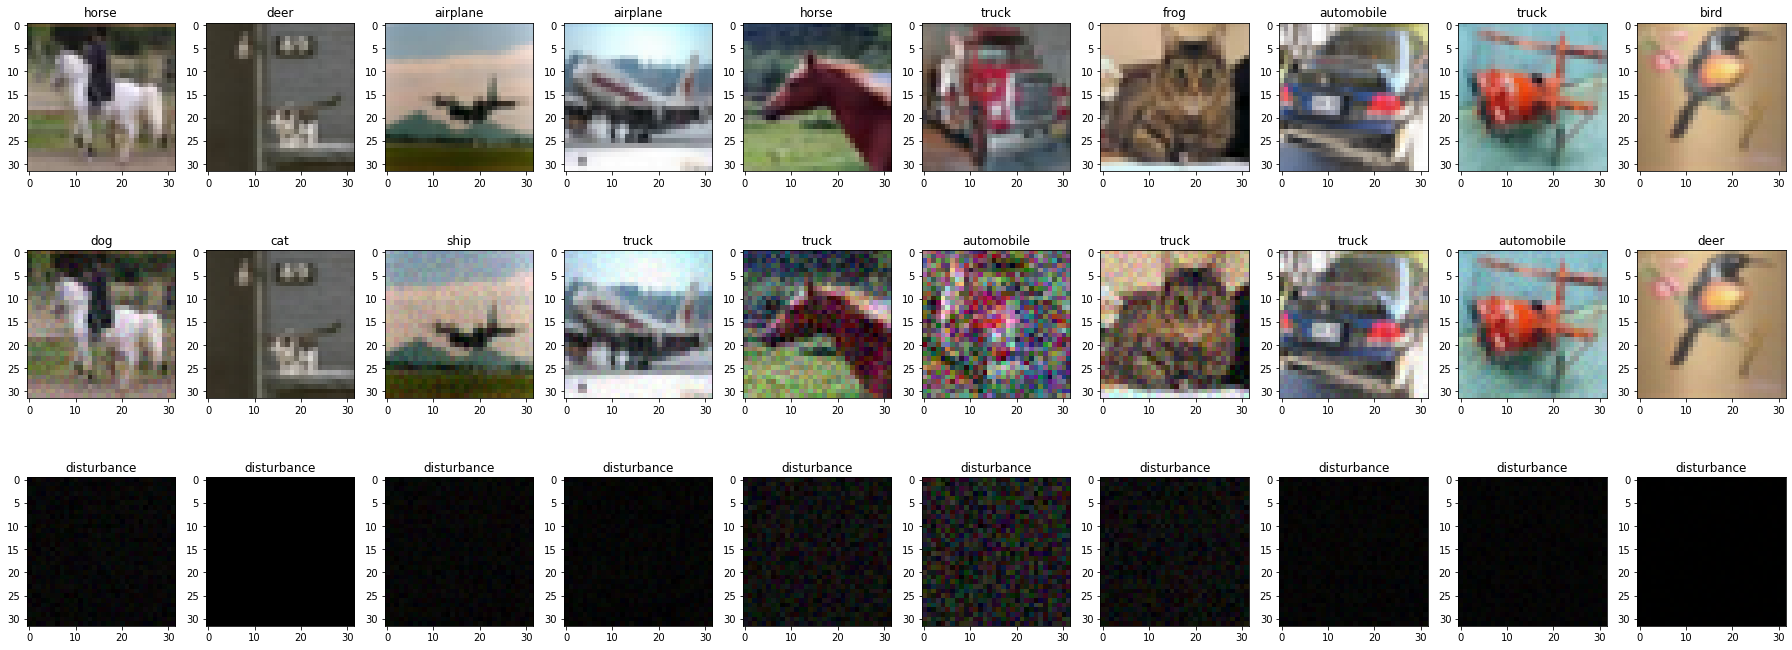

In [19]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.3 Test different Parameters with 100 random examples

In [22]:
with open ('./information/CNN.txt', 'a') as f:
  f.write("Test Untargeted attack accuracy: (max_eval=100, init_eval=10)\n")

for norm in [2, np.inf]:
  for max_iter in [10, 100]:
    attack = HopSkipJump(classifier=classifier, targeted=False, norm=norm, max_iter=max_iter, max_eval=100, init_eval=10, verbose=False)

    x_test_adv = attack.generate(x=x_test_100_ori)

    predictions_adv = classifier.predict(x_test_adv)
    predictions_ori = classifier.predict(x_test_100_ori)

    accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
    accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

    print(f"norm: {norm}, max_iter: {max_iter},  Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%")

    with open ('./information/CNN.txt', 'a') as f:
      f.write(f"norm: {norm}, max_iter: {max_iter},  Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%\n")

with open ('./information/CNN.txt', 'a') as f:
  f.write("\n")

norm: 2, max_iter: 10,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 14.000000000000002%
norm: 2, max_iter: 100,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 15.0%
norm: inf, max_iter: 10,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 12.0%
norm: inf, max_iter: 100,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 15.0%


## 3.2 Test Target Attack

In [23]:
def generate_random_target(ori_target, classes_num):
  class_y_test = np.argmax(ori_target, axis=1)
  nb_classes = np.unique(class_y_test).shape[0]
  targets = np.random.randint(nb_classes, size=len(ori_target))
  for i in range(len(ori_target)):
      if class_y_test[i] == targets[i]:
          targets[i] -= 1

  targets = tf.one_hot(targets, classes_num)

  return targets

##### 2.2.2.1 Use 10 samples for showing difference and effects

In [ ]:
targets = generate_random_target(y_test_10, 10)

### 3.1.1 L2 attack

In [ ]:
attack = HopSkipJump(classifier=classifier, targeted=False, norm=2, max_iter=20, max_eval=100, init_eval=10, verbose=False)

Use 10 samples for showing difference and effects

In [ ]:
x_test_adv = attack.generate(x=x_test_10_ori, y=targets)

In [ ]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.2 L-infinite attack

In [ ]:
attack = HopSkipJump(classifier=classifier, targeted=False, norm=np.inf, max_iter=20, max_eval=100, init_eval=10, verbose=False)

Use 10 samples for showing difference and effects

In [ ]:
x_test_adv = attack.generate(x=x_test_10_ori, y=targets)

In [ ]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.3 Test different Parameters with 100 random examples

In [24]:
with open ('./information/CNN.txt', 'a') as f:
  f.write("Test Targeted attack accuracy: (max_eval=100, init_eval=10)\n")

for norm in [2, np.inf]:
  for max_iter in [10, 100]:
    attack = HopSkipJump(classifier=classifier, targeted=False, norm=norm, max_iter=max_iter, max_eval=100, init_eval=10, verbose=False)

    targets = generate_random_target(y_test_10, 100)

    x_test_adv = attack.generate(x=x_test_100_ori, y=targets)

    predictions_adv = classifier.predict(x_test_adv)
    predictions_ori = classifier.predict(x_test_100_ori)

    accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
    accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

    print(f"norm: {norm}, max_iter: {max_iter},  Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%")

    with open ('./information/CNN.txt', 'a') as f:
      f.write(f"norm: {norm}, max_iter: {max_iter},  Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%\n")

with open ('./information/CNN.txt', 'a') as f:
  f.write("\n")

norm: 2, max_iter: 10,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 14.000000000000002%
norm: 2, max_iter: 100,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 17.0%
norm: inf, max_iter: 10,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 14.000000000000002%
norm: inf, max_iter: 100,  Accuracy before attack: 56.00000000000001%, Accuracy after attack: 16.0%
